<a href="https://colab.research.google.com/github/ssktotoro/neuro/blob/tutorial_branch/Neuro_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Authors: [Kevin Wang](https://github.com/ssktotoro/), [Alex Fedorov](https://github.com/Entodi/), [Sergey Kolesnikov](https://github.com/Scitator)

[![Catalyst logo](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)](https://github.com/catalyst-team/catalyst)

### Colab setup

First of all, do not forget to change the runtime type to GPU. <br/>
To do so click `Runtime` -> `Change runtime type` -> Select `\"Python 3\"` and `\"GPU\"` -> click `Save`. <br/>
After that you can click `Runtime` -> `Run all` and watch the tutorial.

In [ ]:
%%bash 
git clone https://github.com/ssktotoro/neuro.git -b tutorial_branch
pip install -r neuro/requirements/requirements.txt

In [1]:
import torch
import nibabel as nib
from catalyst.metrics.functional._segmentation import dice
import matplotlib.pyplot as plt

%matplotlib inline

from infer import Predictor
from training.model import MeshNet, UNet

/home/users/kwang26/anaconda3/envs/neuro/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
volume_shape = [256, 256, 256]
subvolume_shape = [38, 38, 38]
n_subvolumes = 512
n_classes = 3
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
meshnet_model = MeshNet(n_channels=1, n_classes=n_classes)
meshnet_model.load_state_dict(torch.load('training/logs/meshnet_gmwm_large/train.30_full.pth', map_location=device)['model_state_dict'])
meshnet_predictor = Predictor(meshnet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

unet_model = UNet(n_channels=1, n_classes=n_classes)
unet_model.load_state_dict(torch.load('training/logs/unet_gmwm/train.30_full.pth', map_location=device)['model_state_dict'])
unet_predictor = Predictor(unet_model, volume_shape, subvolume_shape, n_subvolumes, n_classes)

In [3]:
! wget -nc https://dl.dropbox.com/s/g1vn5p3grifro4d/T1w.nii.gz

File ‘T1w.nii.gz’ already there; not retrieving.



In [4]:
img = nib.load('T1w.nii.gz')
img = img.get_fdata()
meshnet_predicted_segmentation = meshnet_predictor.predict('T1w.nii.gz')
unet_predicted_segmentation = unet_predictor.predict('T1w.nii.gz')

In [5]:
%time meshnet_predicted_segmentation = meshnet_predictor.predict('T1w.nii.gz')

CPU times: user 27min 1s, sys: 8.42 s, total: 27min 10s
Wall time: 55.9 s


In [6]:
%time unet_predicted_segmentation = unet_predictor.predict('T1w.nii.gz')

CPU times: user 1h 17min 44s, sys: 5min 2s, total: 1h 22min 46s
Wall time: 2min 54s


In [7]:
def show_slices(slices, raw=True):
    if raw:
        cmap = 'jet'
    else:
        cmap = 'nipy_spectral'
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='nipy_spectral')

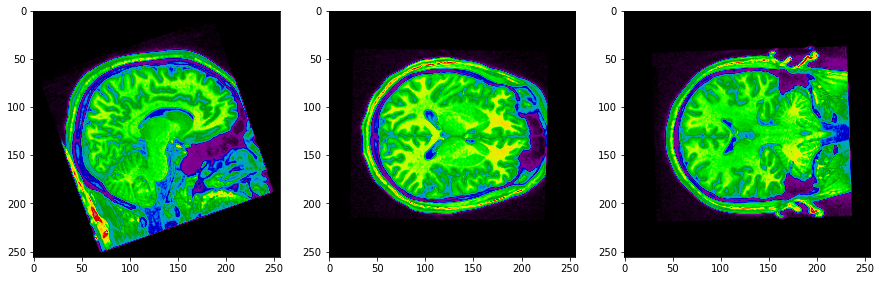

In [8]:
show_slices(
    [img[120, :,:], 
     img[:, 120,:], 
     img[:, :, 120]])

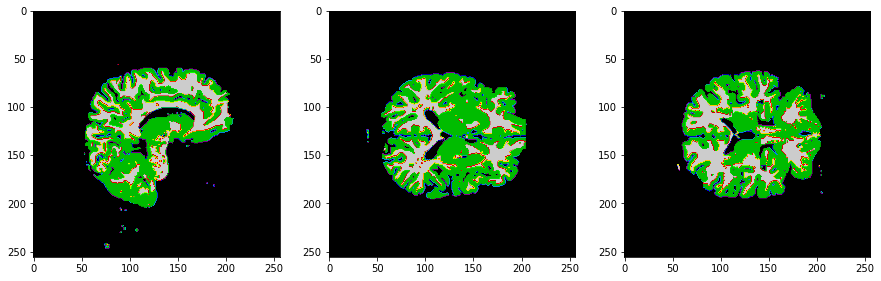

In [9]:
show_slices(
    [meshnet_predicted_segmentation[120, :,:], 
     meshnet_predicted_segmentation[:, 120,:], 
     meshnet_predicted_segmentation[:, :, 120]], raw=False)

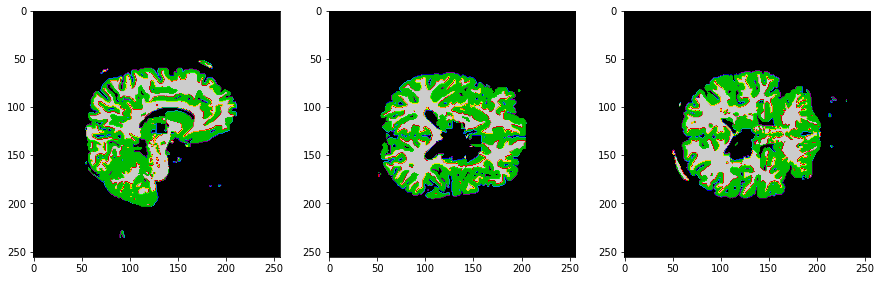

In [10]:
show_slices(
    [unet_predicted_segmentation[120, :,:], 
     unet_predicted_segmentation[:, 120,:], 
     unet_predicted_segmentation[:, :, 120]], raw=False)